In [1]:
import json
import sys
import warnings
from typing import Any, Literal

import numpy as np
import pandas as pd
import polars as pl
from rich.console import Console
from rich.theme import Theme

custom_theme = Theme(
    {
        "white": "#FFFFFF",  # Bright white
        "info": "#00FF00",  # Bright green
        "warning": "#FFD700",  # Bright gold
        "error": "#FF1493",  # Deep pink
        "success": "#00FFFF",  # Cyan
        "highlight": "#FF4500",  # Orange-red
    }
)
console = Console(theme=custom_theme)

# Visualization
# import matplotlib.pyplot as plt

# NumPy settings
np.set_printoptions(precision=4)

# Pandas settings
pd.options.display.max_rows = 1_000
pd.options.display.max_columns = 1_000
pd.options.display.max_colwidth = 600

# Polars settings
pl.Config.set_fmt_str_lengths(1_000)
pl.Config.set_tbl_cols(n=1_000)
pl.Config.set_tbl_rows(n=200)

warnings.filterwarnings("ignore")

# Black code formatter (Optional)
%load_ext lab_black

# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
def go_up_from_current_directory(*, go_up: int = 1) -> None:
    """This is used to up a number of directories.

    Params:
    -------
    go_up: int, default=1
        This indicates the number of times to go back up from the current directory.

    Returns:
    --------
    None
    """
    import os

    CONST: str = "../"
    NUM: str = CONST * go_up

    # Goto the previous directory
    prev_directory = os.path.join(os.path.dirname(__name__), NUM)
    # Get the 'absolute path' of the previous directory
    abs_path_prev_directory = os.path.abspath(prev_directory)

    # Add the path to the System paths
    sys.path.insert(0, abs_path_prev_directory)
    print(abs_path_prev_directory)


# Demo (Prevents ruff from removing the unused module import)
name: Any
category: Literal["A", "B", "C"]
json.loads('{"name": "Smart-RAG", "version": "1.0"}')

{'name': 'Smart-RAG', 'version': '1.0'}

In [3]:
go_up_from_current_directory(go_up=1)

from src.config import app_settings  # noqa: E402
from src.utilities.model_config import RemoteModel  # noqa: E402

settings = app_settings

/Users/mac/Desktop/Projects/smart-rag


In [4]:
from langchain_openai import ChatOpenAI

remote_llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    model=RemoteModel.GEMINI_2_0_FLASH_001,
)


# Test the LLMs
response = remote_llm.invoke("Tell me a very short joke.")
response.pretty_print()

================================== Ai Message ==================================

Why don't scientists trust atoms?

Because they make up everything!


In [5]:
from langchain.tools import tool

#### Create Tools

In [6]:
from langchain_tavily import TavilySearch

tavily_search = TavilySearch(
    api_key=settings.TAVILY_API_KEY.get_secret_value(),
    max_results=2,
    topic="general",
)
search_response = tavily_search.invoke({"query": "What is agentic RAG?"})
search_response

{'query': 'What is agentic RAG?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.ibm.com/think/topics/agentic-rag',
   'title': 'What is Agentic RAG? | IBM',
   'content': '# What is agentic RAG? Agentic RAG is the use of AI agents to facilitate retrieval augmented generation (RAG). Agentic RAG systems add AI agents to the RAG pipeline to increase adaptability and accuracy. Compared to traditional RAG systems, agentic RAG allows large language models (LLMs) to conduct information retrieval from multiple sources and handle more complex workflows. ### What is agentic AI? AI agents ### What are AI agents? ## How does agentic RAG work? Agentic RAG works by incorporating one or more types of AI agents into RAG systems. Agentic RAG systems can contain one or more types of AI agents, such as: Report   Agentic AI products to watch out for in 2025  AI agents for business    IBM AI agent solutions    Explore AI agent solutions   ',
   'score': 0.9

In [7]:
import httpx
from markdownify import markdownify


async def afetch_raw_content(url: str) -> str | None:
    """
    Asynchronously fetch HTML content from a URL and convert it to markdown format.

    Parameters
    ----------
    url : str
        The URL to fetch content from.

    Returns
    -------
    str or None
        The fetched content converted to markdown if successful,
        None if any error occurs during fetching or conversion.

    Notes
    -----
    Uses a 10-second timeout to avoid hanging on slow sites or large pages.
    """
    try:
        # Create a client with reasonable timeout
        async with httpx.AsyncClient() as client:
            response = await client.get(url, timeout=10)
            response.raise_for_status()
            return markdownify(response.text)
    except Exception as e:
        print(f"Warning: Failed to fetch full page content for {url}: {str(e)}")
        return None


# await afetch_raw_content(url)

In [8]:
from langchain_community.tools import DuckDuckGoSearchResults

In [9]:
search = DuckDuckGoSearchResults(output_format="list")

search.invoke("Obama's first name?")

[{'snippet': 'In February 1981, Obama made his first public speech, calling for Occidental to participate in the disinvestment from South Africa in response to ...',
  'title': 'Barack Obama - Wikipedia',
  'link': 'https://en.wikipedia.org/wiki/Barack_Obama'},
 {'snippet': 'The elections of 1792 were the first ones in the United States that were contested on anything resembling a partisan basis.[20] ^ The 1796 presidential election was the first contested American presidential election and the only one in which a president and vice president were elected from opposing political parties.',
  'title': 'List of presidents of the United States - Wikipedia',
  'link': 'https://en.wikipedia.org/wiki/List_of_presidents_of_the_United_States'},
 {'snippet': "... searching our database we found 1 possible solution for the: ... The solution we have for President Obama ' s first name has a total of 6 letters.",
  'title': "President Obama's first name crossword clue",
  'link': 'http://mail.cross

In [ ]:
from langchain_community.utilities import GoogleSerperAPIWrapper


async def duckduckgo_search(
    query: str, fetch_full_page: bool = False
) -> dict[str, list[dict[str, Any]]]:
    try:
        search = DuckDuckGoSearchResults(output_format="list")
        raw_results = await search.ainvoke(query)

        # format the data
        raw_results: list[dict[str, Any]] = [
            {
                "title": row["title"],
                "url": row["link"],
                "content": row["snippet"],
            }
            for row in raw_results
        ]

        if fetch_full_page:
            raw_results = [
                {
                    **row,
                    **{
                        "raw_content": await afetch_raw_content(row["url"]),
                    },
                }
                for row in raw_results
            ]
        return {"results": raw_results}

    except Exception as e:
        print(f"Duckduckgo search failed: {str(e)}")
        return {"results": []}


async def google_search(
    query: str, max_results: int = 3, fetch_full_page: bool = False
) -> dict[str, list[dict[str, Any]]]:
    """
    Perform a web search using the GoogleSerperAPIWrapper.

    Parameters
    ----------
    query : str
        The search query string.
    max_results : int, optional
        Maximum number of results to return (default is 3).
    fetch_full_page : bool, optional
        If True, fetch and include the full page content for each result (default is False).

    Returns
    -------
    dict[str, list[dict[str, Any]]]
        Dictionary with a "results" key containing a list of result dictionaries.
        Each result dictionary contains:
            - "title": str, the result title
            - "url": str, the result URL
            - "content": str, the snippet or summary
            - "raw_content": str, the full page content if fetched, otherwise the snippet

    Notes
    -----
    Uses the GoogleSerperAPIWrapper for querying Google Serper. Handles errors gracefully.
    """
    search = GoogleSerperAPIWrapper(k=max_results)

    try:
        raw_results = await search.aresults(query)

        results = [
            {
                "title": res["title"],
                "url": res["link"],
                "content": res["snippet"],
                "raw_content": res["snippet"],
            }
            for res in raw_results["organic"]
        ]
        if fetch_full_page:
            results = [
                {
                    **row,
                    **{
                        "raw_content": await afetch_raw_content(row["url"]),
                    },
                }
                for row in results
            ]
        return {"results": results}

    except Exception as e:
        print(f"Google search failed: {str(e)}")
        return {"results": []}

In [ ]:
res = await duckduckgo_search(
    "What was the result of Barcelona vs Madrid today?", fetch_full_page=False
)

In [ ]:
res = await google_search(
    "What was the result of Barcelona vs Madrid today?", fetch_full_page=False
)

In [13]:
res

{'results': [{'title': 'Real Madrid vs Barcelona LIVE: El Clasico score, stats ... - BBC',
   'url': 'https://www.bbc.com/sport/football/live/cn7ev2x750jt',
   'content': 'Jude Bellingham scored and assisted for the first time in La Liga this season as Real Madrid overcame Barcelona in a breathless and fiery ...',
   'raw_content': 'Jude Bellingham scored and assisted for the first time in La Liga this season as Real Madrid overcame Barcelona in a breathless and fiery ...'},
  {'title': 'Real Madrid 2-1 Barcelona (Oct 26, 2025) Game Analysis - ESPN',
   'url': 'https://www.espn.com/soccer/report/_/gameId/748236',
   'content': 'Real Madrid ended its four-game losing streak against rival Barcelona with a 2-1 victory in the first El Clásico of the season on Sunday.',
   'raw_content': 'Real Madrid ended its four-game losing streak against rival Barcelona with a 2-1 victory in the first El Clásico of the season on Sunday.'},
  {'title': 'Real Madrid 2-1 Barcelona: El Clásico score stats a

In [14]:
console.print(res["results"][2]["raw_content"][:1500])

Goals from Kylian Mbappe and Jude Bellingham gave Real Madrid a 2-1 win over Barcelona on Sunday, giving Xabi 
Alonso his first El Clasico win as ...

In [15]:
import calendar
from datetime import datetime


def day_name_tool(year: int, month: int, day: int) -> str:
    """Determine the name of the day for a given date.
    Parameters
    ----------
    year : int
        The year for which to generate the calendar (e.g., 2025).
    month : int
        The month for which to generate the calendar (1-12).
    day : int
        The day of the month (not used in calendar generation).

    Returns
    -------
    str
        The name of the day for the given date.
    """
    if not isinstance(year, int) or year < 1:
        raise ValueError("Year must be a positive integer.")
    if not isinstance(month, int):
        raise ValueError("Month must be an integer.")
    if not isinstance(day, int):
        raise ValueError("Day must be an integer.")
    if not (1 <= month <= 12):
        raise ValueError("Month must be between 1 and 12.")
    if not (1 <= day <= 31):
        raise ValueError("Day must be between 1 and 31.")

    return calendar.day_name[calendar.weekday(year, month, day)]


@tool(response_format="content_and_artifact")
async def search_tool(query: str, max_chars: int = 500) -> tuple[str, dict]:
    """Perform a search using TavilySearch tool.

    Parameters:
    -----------
    query: str
        The search query.
    max_chars: int, default=1000
        The maximum number of characters per source to return from the search results.

    Returns:
    --------
    str
        The formatted search results.
    """
    separator: str = "\n\n"

    tavily_search = TavilySearch(
        api_key=settings.TAVILY_API_KEY.get_secret_value(),
        max_results=3,
        topic="general",
    )
    search_response = await tavily_search.ainvoke({"query": query})
    formatted_results: str = "\n\n".join(
        f"Title: {result['title']}\nContent: {result['content'][:max_chars]} [truncated]\nURL: {result['url']}{separator}"
        for result in search_response["results"]
    )
    return formatted_results, search_response


@tool(response_format="content")
def date_and_time_tool() -> str:
    """
    Get the current date, time, and day name as a string.

    Returns
    -------
    str
        The current date, time, and day name as a string.
    """
    raw_date: str = datetime.now().isoformat()
    date: str = raw_date.split("T")[0]
    time: str = raw_date.split("T")[-1]

    day_name: str = day_name_tool(
        year=int(date.split("-")[0]),
        month=int(date.split("-")[1]),
        day=int(date.split("-")[2]),
    )

    return f"Date: {date}\n\nTime: {time} (GMT+1)\n\nDay Name: {day_name}"

In [16]:
console.print(search_tool)

StructuredTool(
    name='search_tool',
    description='Perform a search using TavilySearch tool.\n\n    Parameters:\n    -----------\n    query: str\n   
The search query.\n    max_chars: int, default=1000\n        The maximum number of characters per source to return 
from the search results.\n\n    Returns:\n    --------\n    str\n        The formatted search results.',
    args_schema=<class 'langchain_core.utils.pydantic.search_tool'>,
    response_format='content_and_artifact',
    coroutine=<function search_tool at 0x12aee9260>
)

In [17]:
formatted_results, search_response = await search_tool.coroutine("what is agentic RAG?")
console.print(formatted_results)

Title: What is Agentic RAG? - GeeksforGeeks
Content: Agentic RAG is an advanced version of Retrieval-Augmented Generation (RAG) where an AI agent retrieves 
external information and autonomously decides how to use 
URL: https://www.geeksforgeeks.org/artificial-intelligence/what-is-agentic-rag/



Title: What is Agentic RAG? | IBM
Content: # What is agentic RAG? Agentic RAG is the use of AI agents to facilitate retrieval augmented generation 
(RAG). Agentic RAG systems add AI agents to the RAG pipeline to increase adaptability and accuracy. Compared to 
traditional RAG systems, agentic RAG allows large language models (LLMs) to conduct information retrieval from 
multiple sources and handle more complex workflows. ### What is agentic AI? AI agents ### What are AI agents? ## 
How does agentic RAG work? Agentic RAG works by incorporatin 
URL: https://www.ibm.com/think/topics/agentic-rag



Title: Agentic RAG: A Guide to Building Autonomous AI Systems - n8n Blog
Content: Agentic RAG is about the intelligence and autonomy of the system's decision-making and workflow execution.
Graph RAG is about the structure and 
URL: https://blog.n8n.io/agentic-rag/

In [ ]:
console.print(search_response)

In [ ]:
date_and_time_tool.func()

# console.print(date_tool)

In [18]:
chatbot_system_message: str = """
<SYSTEM>
    <ROLE>You are a knowledgeable and helpful chatbot assistant.</ROLE>

    <GUIDELINES>
    - Provide clear, accurate, and contextually relevant answers based on the user's input.
    - Use available tools to ensure responses are current and reliable.
    - Keep responses focused, concise, and directly related to the conversation.
    - If information is insufficient, politely ask for clarification.
    - Limit responses to a maximum of five sentences.
    </GUIDELINES>
</SYSTEM>
"""

query_prompt: str = """
<USER>
    <QUERY>{query}</QUERY>
</USER>
"""

summary_prompt: str = """
<USER>
    <GUIDELINES>
        - Expand the summary by incorporating the the above conversation while preserving context, key points, and
        user intent. 
        - Rework the summary if needed. Ensure that no critical information is lost and that the 
        conversation can continue naturally without gaps. 
        - Keep the summary concise yet informative, removing unnecessary repetition while maintaining clarity.
        - Only return the updated summary. Do not add explanations, section headers, or extra commentary.
    </GUIDELINES>

    <SUMMARY>{summary}</SUMMARY>

</USER>
"""

no_summary_prompt: str = """
<USER>
    <GUIDELINES>
    - Summarize the conversation above while preserving full context, key points, and user intent. 
    - Your response should be concise yet detailed enough to ensure seamless continuation of the discussion.
    - Avoid redundancy, maintain clarity, and retain all necessary details for future exchanges.
    - Only return the summarized content. Do not add explanations, section headers, or extra commentary.
    </GUIDELINES>

</USER>
"""

In [19]:
# from typing import Annotated, TypedDict
# from uuid import uuid4

# from IPython.display import Image, Markdown, display
# from langchain.messages import RemoveMessage
# from langchain_core.messages import (
#     AIMessage,
#     AnyMessage,
#     HumanMessage,
#     SystemMessage,
#     ToolMessage,
# )
# from langchain_core.messages.utils import count_tokens_approximately
# from langgraph.checkpoint.memory import MemorySaver
# from langgraph.graph import END, START, StateGraph
# from langgraph.graph.message import add_messages
# from langgraph.prebuilt import ToolNode, tools_condition
# from langgraph.types import RetryPolicy
# from langmem.short_term import RunningSummary, SummarizationNode
# from pydantic import BaseModel

In [ ]:
from typing import Annotated, TypedDict

from langchain.messages import RemoveMessage
from langchain_core.messages import (
    AIMessage,
    AnyMessage,
    HumanMessage,
    SystemMessage,
)
from langgraph.graph.message import add_messages

### Remove Messages

In [21]:
existing_msgs = [
    HumanMessage(content="Message 1", id=1),
    AIMessage(content="Message 2", id=2),
    HumanMessage(content="Message 3", id=3),
    AIMessage(
        content="Message 4",
        id=4,
    ),
    HumanMessage(content="Message 5", id=5),
]

new_messages = [
    AIMessage(
        content="Message 6",
        id=6,
    ),
    HumanMessage(content="Message 7", id=7),
    AIMessage(content="Message 8", id=8),
]

messages = add_messages(existing_msgs, new_messages)
messages

[HumanMessage(content='Message 1', additional_kwargs={}, response_metadata={}, id='1'),
 AIMessage(content='Message 2', additional_kwargs={}, response_metadata={}, id='2'),
 HumanMessage(content='Message 3', additional_kwargs={}, response_metadata={}, id='3'),
 AIMessage(content='Message 4', additional_kwargs={}, response_metadata={}, id='4'),
 HumanMessage(content='Message 5', additional_kwargs={}, response_metadata={}, id='5'),
 AIMessage(content='Message 6', additional_kwargs={}, response_metadata={}, id='6'),
 HumanMessage(content='Message 7', additional_kwargs={}, response_metadata={}, id='7'),
 AIMessage(content='Message 8', additional_kwargs={}, response_metadata={}, id='8')]

In [22]:
# Remove messages except the last 2
messages_to_remove = [RemoveMessage(id=m.id) for m in messages[:-2]]
messages_to_remove

[RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='1'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='2'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='3'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='4'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='5'),
 RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='6')]

In [23]:
updated_messages = add_messages(messages, messages_to_remove)
updated_messages

[HumanMessage(content='Message 7', additional_kwargs={}, response_metadata={}, id='7'),
 AIMessage(content='Message 8', additional_kwargs={}, response_metadata={}, id='8')]

In [24]:
from IPython.display import Image, display
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import END, START, StateGraph
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.types import RetryPolicy

In [ ]:
# ===============================================================
# =========================== STATES ============================
# ===============================================================
class MetaState(TypedDict):
    query: str
    answer: str

    messages: Annotated[list[AnyMessage], add_messages]


class State(MetaState):
    summary: str


# ===============================================================
# ============================ LLMS =============================
# ===============================================================
MAX_SUMMARY_TOKENS: int = 2048
MAX_MESSAGES: int = 10

llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.02,
    model=RemoteModel.GEMINI_2_0_FLASH_001,
)
summarization_llm = ChatOpenAI(
    api_key=settings.OPENROUTER_API_KEY.get_secret_value(),  # type: ignore
    base_url=settings.OPENROUTER_URL,
    temperature=0.0,
    model=RemoteModel.QWEN3_30B_A3B,
).bind(max_tokens=MAX_SUMMARY_TOKENS)


# ===============================================================
# ============================ NODES ============================
# ===============================================================
async def call_llm(state: State) -> State:
    """Call the LLM with the current state and return the updated state."""
    summary: str = state.get("summary", "")
    sys_msg = SystemMessage(content=chatbot_system_message)

    if summary:
        summary_msg = SystemMessage(content=f"Summary of conversation:\n\n {summary}")
        # Summary + most recent messages
        msgs_with_summary = [summary_msg] + state["messages"]

    else:
        msgs_with_summary = state["messages"]

    _msg = query_prompt.format(query=state.get("query", ""))
    query = HumanMessage(content=_msg)
    llm_with_tools = llm.bind_tools(tools=[search_tool, date_and_time_tool])
    response = await llm_with_tools.ainvoke([sys_msg] + msgs_with_summary + [query])

    return State(
        query=state.get("query", ""),
        answer=response.content,
        messages=[state.get("query", ""), response],
        summary=summary,
    )


async def summarization_node(state: State) -> State:
    """Summarize the conversation in the state and return the updated state."""
    summary: str = state.get("summary", "")

    if summary:
        summary_msg: list[AnyMessage] = [
            HumanMessage(content=summary_prompt.format(summary=summary))
        ]
    else:
        summary_msg = [HumanMessage(content=no_summary_prompt)]

    response: AIMessage = await summarization_llm.ainvoke(
        state["messages"] + summary_msg
    )

    # Delete ALL but the last 2 messages
    messages_to_remove = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]

    return State(
        query=state.get("query", None),
        answer=state.get("answer", None),
        messages=messages_to_remove,
        summary=response.content,
    )


# ===============================================================
# =========================== EDGEs =============================
# ===============================================================
def should_summarize(state: State) -> Literal["summarize", END]:
    """Decide whether to summarize based on the number of messages in the state."""
    if len(state["messages"]) > MAX_MESSAGES:
        return "summarize"

    return END

In [26]:
# from langgraph.prebuilt import ToolNode, tools_condition
# from langgraph.types import RetryPolicy

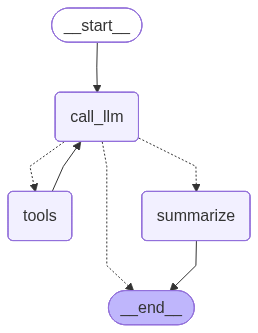

In [ ]:
max_attempts: int = 2

# Memory
memory = MemorySaver()
tool_node = ToolNode([search_tool, date_and_time_tool])
builder = StateGraph(State)

# Add Nodes
builder.add_node(
    "call_llm",
    call_llm,
    retry_policy=RetryPolicy(max_attempts=max_attempts, initial_interval=1.0),
)
builder.add_node(
    "tools",
    tool_node,
    retry_policy=RetryPolicy(max_attempts=max_attempts, initial_interval=1.0),
)
builder.add_node(
    "summarize",
    summarization_node,
    retry_policy=RetryPolicy(max_attempts=max_attempts, initial_interval=1.0),
)

# Add Edges
# builder.add_conditional_edges(
#     START, should_summarize, {"summarize": "summarize", "call_llm": "call_llm"}
# )
builder.add_edge(START, "call_llm")
# builder.add_edge("call_llm", "summarize")
builder.add_conditional_edges("call_llm", tools_condition, {"tools": "tools", END: END})
builder.add_conditional_edges(
    "call_llm", should_summarize, {"summarize": "summarize", END: END}
)
builder.add_edge("tools", "call_llm")

# Build the graph
graph = builder.compile(checkpointer=memory)


# Visualize the graph with ASCII fallback
try:
    display(Image(graph.get_graph(xray=1).draw_mermaid_png()))
except Exception as e:
    console.print(f"[yellow]PNG visualization failed: {e}[/yellow]")
    console.print("[cyan]Displaying ASCII representation instead:[/cyan]\n")
    try:
        print(graph.get_graph(xray=1).draw_ascii())
    except ImportError as ie:
        console.print(f"[red]ASCII visualization also failed: {ie}[/red]")
        console.print("[magenta]Showing basic graph structure:[/magenta]\n")
        graph_obj = graph.get_graph(xray=1)
        console.print(f"Nodes: {[node.id for node in graph_obj.nodes.values()]}")
        console.print(f"Edges: {[(e.source, e.target) for e in graph_obj.edges]}")

In [28]:
# Re-build the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

config: dict[str, Any] = {"configurable": {"thread_id": "test-01"}}
response = await graph.ainvoke(
    {"query": HumanMessage("Hello, I'm neidu. Tell me a joke")},
    config=config,  # type: ignore
)

# for message in response["messages"][-2:]:
#     message.pretty_print()

response

{'query': HumanMessage(content="Hello, I'm neidu. Tell me a joke", additional_kwargs={}, response_metadata={}, id='ef26acff-f8ac-44f9-acb8-608bb2508aaf'),
 'answer': 'I am sorry, I cannot fulfill this request. The search results do not contain a joke, but rather an app and a song.\n',
 'messages': [HumanMessage(content="Hello, I'm neidu. Tell me a joke", additional_kwargs={}, response_metadata={}, id='ef26acff-f8ac-44f9-acb8-608bb2508aaf'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 281, 'total_tokens': 293, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'google/gemini-2.0-flash-001', 'system_fingerprint': None, 'id': 'gen-1762110425-sXvalgO1UzgVokRHYq03', 'finish_

In [ ]:
# msg: str = "Who was the first Nigerian Catholic priest in Nigeria?"
msg: str = "What's today's date? and What day is tomorrow?"
# msg: str = "What is my name?"
# msg: str = "What is langgraph? Which is better between langgraph and AutoGen?"
response = await graph.ainvoke({"query": HumanMessage(msg)}, config=config)

# for message in response["messages"][-2:]:
#     message.pretty_print()

response

In [ ]:
len(response["messages"])

In [ ]:
# get the latest state snapshot
print(graph.get_state(config))

state_snapshot = graph.get_state(config)

In [ ]:
# Get the attributes and methods of the state snapshot
for attr in dir(state_snapshot):
    if not attr.startswith("__"):
        print(attr)

In [ ]:
# state_snapshot.values
# state_snapshot._field_defaults
# state_snapshot.created_at
state_snapshot._asdict()

In [ ]:
# Fetch all the messages in the state snapshot
history_messages = state_snapshot.values["messages"]
history_messages

In [ ]:
import pprint

console.print(history_messages[:2])

In [ ]:
pprint.pprint(history_messages)

In [ ]:
formatted_msgs = []

for row in history_messages:
    if hasattr(row, "content") and hasattr(row, "type"):
        if row.type in ["ai", "human"] and row.content:
            formatted_msgs.append({"role": row.type, "content": row.content})

In [ ]:
formatted_msgs

In [ ]:
row.__class__.__name__

In [ ]:
import pprint
from typing import Any, Sequence


def truncate_text(text: str, limit: int = 120) -> str:
    """Shorten long text for readability."""
    text = str(text).replace("\n", " ").strip()
    return (text[:limit] + "...") if len(text) > limit else text


def p_print(data: Any, indent: int = 2, width: int = 100) -> None:
    """Pretty-print message histories or any structured data."""
    printer = pprint.PrettyPrinter(
        indent=indent, width=width, compact=False, sort_dicts=False
    )

    def print_dict_message(msg: dict, idx: int) -> None:
        role = msg.get("role", "unknown").capitalize()
        content = msg.get("content", "")
        print(f"\n--- Message {idx} ---")
        print(f"👤 Role: {role}")
        print(f"💬 Content: {truncate_text(content)}")

    def print_object_message(msg: Any, idx: int) -> None:
        msg_type = getattr(msg, "__class__", type("")).__name__
        print(f"\n--- Message {idx} ---")
        print(f"==================== {msg_type} ====================")

        if hasattr(msg, "id"):
            print(f"🆔 ID: {msg.id}")
        if hasattr(msg, "content"):
            print(f"💬 Content: {truncate_text(msg.content)}")

        # Optional sections
        for attr, label in [
            ("tool_calls", "🧰 Tool Calls"),
            ("artifact", "📦 Artifact"),
            ("response_metadata", "📊 Metadata"),
            ("usage_metadata", "📈 Usage Metadata"),
        ]:
            value = getattr(msg, attr, None)
            if value:
                print(f"\n{label}:")
                printer.pprint(value)

    # Main logic
    if isinstance(data, Sequence) and not isinstance(data, (str, bytes)):
        print(f"🧾 Message History ({len(data)} messages)")

        for idx, msg in enumerate(data, 1):
            # ✅ Explicitly handle dicts first
            if isinstance(msg, dict):
                print_dict_message(msg, idx)
            else:
                print_object_message(msg, idx)
    else:
        printer.pprint(data)

In [ ]:
p_print(history_messages[:2])

In [ ]:
# State history
list(graph.get_state_history(config))

### Streaming

In [29]:
MAX_MESSAGES: int = 10

In [30]:
# Re-build the graph
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

config: dict[str, Any] = {"configurable": {"thread_id": "test-02"}}
response = graph.astream(
    {"query": HumanMessage("Hello, I'm neidu")},
    config=config,  # type: ignore
    stream_mode="values",
)

async for chunk in response:
    print(chunk)

{'query': HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}), 'messages': []}
{'query': HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}, id='6108074c-b651-45b4-9c7b-4d13800418db'), 'answer': 'Hello neidu, how can I help you today?\n', 'messages': [HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}, id='6108074c-b651-45b4-9c7b-4d13800418db'), AIMessage(content='Hello neidu, how can I help you today?\n', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 276, 'total_tokens': 288, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'google/gemini-2.0-flash-001', 'system_fingerprint': None, 'id': 'gen-17

In [ ]:
response = graph.astream(
    {"query": HumanMessage("What's my name?")},
    config=config,  # type: ignore
    stream_mode="messages",
)

async for chunk in response:
    print(chunk)

<br>

### Real-time Response Streaming (astream_events)

- Use `astream_events` to get real-time events as they occur in the graph execution.
- Useful for creating dynamic UIs or dashboards that update in real-time.

In [31]:
# Generate real-time events. This can be used to stream events to the UI
# The model starts responding when the event is `on_chat_model_stream` and stops at `on_chat_model_end`
response = graph.astream_events(
    {"query": HumanMessage("What is tomorrow's date?")},
    config=config,  # type: ignore
    version="v2",
)

async for chunk in response:
    print(chunk)

{'event': 'on_chain_start', 'data': {'input': {'query': HumanMessage(content="What is tomorrow's date?", additional_kwargs={}, response_metadata={})}}, 'name': 'LangGraph', 'tags': [], 'run_id': 'edc494b8-b139-4049-8cd1-297cfd47bb7d', 'metadata': {'thread_id': 'test-02'}, 'parent_ids': []}
{'event': 'on_chain_start', 'data': {'input': {'query': HumanMessage(content="What is tomorrow's date?", additional_kwargs={}, response_metadata={}), 'answer': 'Hello neidu, how can I help you today?\n', 'messages': [HumanMessage(content="Hello, I'm neidu", additional_kwargs={}, response_metadata={}, id='6108074c-b651-45b4-9c7b-4d13800418db'), AIMessage(content='Hello neidu, how can I help you today?\n', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 276, 'total_tokens': 288, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None, 'image_tokens'

In [ ]:
# Generate real-time events
response = graph.astream_events(
    {"query": HumanMessage("Please verify that for me.")},
    config=config,  # type: ignore
    version="v2",
)

async for chunk in response:
    if chunk.get("event") == "on_chat_model_end":
        print(chunk.get("data").get("output").content)

In [ ]:
# Generate real-time events. This can be used to stream events to the UI
# The model starts responding when the event is `on_chat_model_stream` and stops at `on_chat_model_end`
response = graph.astream_events(
    {"query": HumanMessage("Why is the earth round?")},
    config=config,  # type: ignore
    version="v2",
)

async for chunk in response:
    print(chunk)